In [1]:
import sys
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/finance_course/2022/lesson7')

Mounted at /content/drive


* Main challenge in quantitative finance: risk measurement and assessment.

* There is a wide range of risk measures that spread through the Market
  * we will concentrate specifically on two of them: Value at Risk VaR and Rxpected Shortfall ES.

## VaR and Expected Shortfall

* Value-at-risk is defined as the loss level that will not be exceeded with a certain confidence level during a certain period of time.

$$\textrm{VaR}_{\alpha}(X) = -F^{-1}_X(\alpha)$$

* It is the loss corresponding to the $(100-\alpha)\textrm{th}$ percentile of the portfolio returns over the next $N$ days
* By definition it is a function of two parameters: the time horizon (i.e. $N$ days usually set to 1) and the confidence level (usually 95\%). 
* VaR asks the question "how bad can things get ?"

<center>

![](https://drive.google.com/uc?id=1KGeDQ1uEs5O3ve4AFUHirfXvg-YUbfw9)

</center>

* For example, if a bank's 10-day 99\% VaR is 3 million, there is considered to be only a 1\% chance that losses will exceed 3 million in 10 days. 

* If VaR is used to limit the risks taken by a trader, it can lead to undesirable results. 
  * A trader is asked that the one-day 99\% VaR of its portfolio must be kept less than 10 million. The trader could construct a portfolio where there is a 99\% chance that the daily loss is less than 10 million and a 1\% chance that it is 500 million. The trader is satisfying the risk limits imposed by the bank, but is clearly taking unacceptable risks. 

<center>

![](https://drive.google.com/uc?id=1Aal5SZ-yD2EZp_lW9hlNbBCoharaGmsl)

</center>

* A measure that produces better incentives for traders is *expected shortfall*. 
* It is the expected loss during an N-day period, conditional that the loss is greater than the $\alpha^{th}$ percentile of the loss distribution

$$\textrm{ES}_{\alpha}(X) = \frac{1}{\alpha}\int_0^\alpha \textrm{VarR}_p(X) dp$$

*It is the average amount that is lost over a 10-day period, assuming that the loss is greater than the corresponding VaR.
* Expected Shortfall asks "if things do get bad, what is our expected loss ?"

<center>

![](https://drive.google.com/uc?id=109LfaKNqj4M_zqkeChlyy3pUXEREf-Cg)

</center>



* We use a ficticious portfolio: 60\% of AAPL and 40\% NFLX shares. 
* The dataset is avaialble in [historical_data.csv](https://raw.githubusercontent.com/matteosan1/finance_course/develop/libro/input_files/historical_data.csv).

## Parametric VaR, ES

* From the return historical series extract $\mu$ and $\sigma$ from a Gaussian fit of the return distribution obtained from the historical series.
* Apply directly the definitions of VaR and ES.


In [ ]:
import pandas as pd
from scipy.stats import norm
import numpy as np

df = pd.read_csv("https://raw.githubusercontent.com/matteosan1/finance_course/develop/libro/input_files/historical_data.csv", index_col='Date')
df['P'] = df['aapl']*0.6 + df['nflx']*0.4
df = df.pct_change()
df.dropna(inplace=True)

* Numerical integration can be done using $\texttt{scipy.integrate.quad}$, for example

$$\int_{0}^{7} x^2 dx = \frac{x^3}{3}\bigg|_0^7 = 114.3$$

In [ ]:
import numpy as np
from scipy.integrate import quad

def f(x):
  return x**2

print (quad(f, 0, 7))

(114.33333333333334, 1.2693549914880957e-12)


In [ ]:
import numpy as np
from scipy.integrate import quad

mu = df.mean() 
sigma = df.std()

def var_continuous(f, alpha=0.95):
    return -f.ppf(1-alpha)

def es_continuous(f, alpha=0.95):
  def integrand(x, f):
    return f.ppf(x)

  alpha = 1-alpha
  I = quad(integrand, 0, alpha, args=(f,))
  return -1/alpha*I[0]
    
f = norm(mu['P'], sigma['P'])
print ("1d-95% VaR: {:.4}".format(var_continuous(f, 0.95)))
print ("1d-95% ES: {:.4}".format(es_continuous(f, 0.95)))

1d-95% VaR: 0.03186
1d-95% ES: 0.04037


<center>

![](https://drive.google.com/uc?id=1cb6udUY_9jqKiAAUbAwCLMv-HS6Y2vuU)

</center>

* Many theories in finance assume the normality of stock returns, unfortunately normality is not a realistic assumption as can be seen by performing a Gaussian fit to the return distribution.

* A better model results in a more precise estimate of VaR and ES can be obtained with a t-student. 



In [ ]:
from scipy.stats import t

f2 = t.fit(df['P'])
model = t(*f2)

print ("1d-95% VaR: {:.4}".format(var_continuous(model, 0.95)))
print ("1d-95% ES: {:f}".format(es_continuous(model, 0.95)))


1d-95% VaR: 0.02803
1d-95% ES: 0.047245


### Historical Simulation

* Avoid any assumption on the return distribution, by random sampling on the historical returns directly. 
  * The parameter estimation is not required in this case, but heavily relies on the assumption that past behaviors are indicative of what might happen in the future. 
  * Historical series was as large as possible otherwise our results will be affected by lack of statistics. 

<center>

![](https://drive.google.com/uc?id=1QFljTnNxfqD61FEmX3yXkBWRIouecr7j)

</center>


In [ ]:
from numpy.random import choice
from numpy import percentile

def generate_returns(df, N=100000):
    data = df.reset_index()
    return data.loc[choice(range(len(data)), N)]

def var_discrete(df, alpha=0.95):
    alpha = 1-alpha
    return -percentile(df, alpha*100)
    
def es_discrete(df, alpha=0.95):
    alpha = 1-alpha
    var = percentile(df, alpha*100)	
    return -df[df<=var].mean()
    
returns = generate_returns(df, 10000)
print ("1d-95% VaR (discrete): {:.4}".format(var_discrete(returns['P'], 0.95)))
print ("1d-95% ES (discrete): {:f}".format(es_discrete(returns['P'], 0.95)))


1d-95% VaR (discrete): 0.028
1d-95% ES (discrete): 0.047245


### Stress-test and Backtesting

* It is generally useful to check how VaR would behave under the most extreme market moves seen in the last years.
  * This kind of test is called **stress-test**;
  * it is done by extracting from the historical series particular days with exceptionally large variation of the market variables, to take into account extreme events that can happen more frequently in reality than in a simulation (where usually Gaussian tails are assumed). 
  * For example a 5-standard deviation move is expected to happen once every 7000 years but in practice can be observed twice over 10 years.

* **Backtesting** consists of assessing how well the VaR estimate would have performed in the past. 
  * Basically it has to be tested how often the daily loss exceeded the daily X% VaR just computed. 
    * If it happens on about (100- X)% of the times we can be confident that our estimate is correct. 
    * Clearly back-testing makes sense only if VaR has been estimated on an independent historical sample with respect to that used in the test.

In [ ]:
print ((df['P'] < -0.02804).sum()/len(df))

0.04976525821596244


## Credit VaR

* Credit VaR is defined as a percentile of the **credit loss** distribution. 
  * In this case we are concerned with the default risk associated to counter-parties instead of the market risk.
* The **exposure** $EE(\tau)$ defined as the sum of the discounted cash flows at the default date $\tau$. 
* The corresponding **loss** is then given by $L =(1−R)·EE(\tau)$
  * where $L$ is non-zero only in scenarios of early counter-party default.
* Credit VaR can be expressed as the $\alpha$-quantile of the distribution of $L$. 
  * Time horizon is usually set to one year and the percentile to the 99.9th, so it returns the loss that is exceeded only in 1 case out of 1000.

### Credit VaR and MC Simulation
* Credit VaR can be calculated through a simulation of the evolution of a portfolio up to the risk horizon, including possible defaults of the counter-parties.
* In each experiment the portfolio is priced obtaining a number of scenarios to draw the loss distribution.

#### Example
* Consider a portfolio of 20 zero coupon bonds each one with a default probability of 8% and the same face value (100 EUR). The recovery rate in case of default is 40% and the risk free rate is 1%.

In [21]:
from finmarkets import generate_dates

class Bond:
  def __init__(self, face_value, start_date, coupon, tenor_months, maturity_years):
    self.FV = face_value
    self.C = coupon
    self.tau = tenor_months/12
    self.payment_dates = generate_dates(start_date, maturity_years*12, tenor_months)

  def npv(self, dc, def_date):
    val = 0
    for i in range(1, len(self.payment_dates)):
      if self.payment_dates[i-1] <= def_date < self.payment_dates[i]:
        rateo = (self.payment_dates[i] - def_date).days/(self.payment_dates[i] - self.payment_dates[i-1]).days
        val += self.C*rateo*self.tau*dc.df(def_date)
      elif self.payment_dates[i] > def_date:  
        val += self.C*self.tau*dc.df(self.payment_dates[i])
    val += dc.df(self.payment_dates[-1])
    return self.FV*val

In [26]:
import pandas as pd
import numpy as np
from datetime import date
from dateutil.relativedelta import relativedelta
from finmarkets import DiscountCurve, CreditCurve, ExpDefault
from scipy.stats import multivariate_normal, norm

start_date = date.today()
df = pd.read_excel("https://github.com/matteosan1/finance_course/raw/develop/libro/input_files/discount_factors_2022-10-05.xlsx")
pillars = [start_date + relativedelta(months=i) for i in df['months']]
dc = DiscountCurve(pillars, df['dfs'])

bonds = []
maturity = 2
coupons = [0.01, 0.02, 0.03, 0.04, 0.05]
for i in range(len(coupons)):
  bonds.append(Bond(100, start_date, coupons[i], 1, maturity))

np.random.seed(1)
N = 10000
rho = 0.0
l = 0.5
R = 0.4
horizon = 1

Q = ExpDefault(l)
cov = np.ones(shape=(len(bonds), len(bonds)))*rho
np.fill_diagonal(cov, 1)
mean = np.zeros(len(bonds))
mv = multivariate_normal(mean=mean, cov=cov)
x = mv.rvs(size=N)
copula = norm.cdf(x)
taus = Q.ppf(copula)

L = []
for n in range(N):
  EE = 0
  for i, b in enumerate(bonds):
    if taus[n, i] <= horizon:
      d = start_date + relativedelta(days=365*taus[n, i])
      EE += b.npv(dc, d)
  if EE != 0:
    L.append((1-R)*EE)

print (np.percentile(L, 99.9))

300.8841179439165


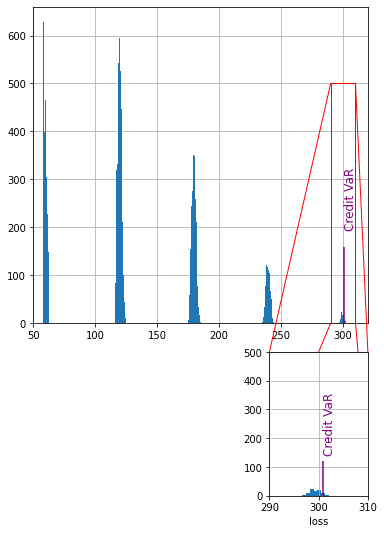

In [27]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import ConnectionPatch

plt.rcParams['figure.figsize'] = (6,9)
ax1 = plt.subplot2grid((3,3),(0,0), colspan = 3, rowspan=2)
ax2 = plt.subplot2grid((3,3),(2,2), colspan = 1)

y, x, _ = ax1.hist(L, bins=320)
ax1.set_xlim(50, 320)
ax1.vlines(np.percentile(L, 99.9), 0, y[1]*0.4, color='purple')
ax1.text(np.percentile(L, 99.9), y[1]*0.5, "Credit VaR", fontsize=12, color='purple', rotation=90)
ax1.grid(True)
ax1.set_axisbelow(True)
ax1.add_patch(Rectangle((290, 0), 20, 500, edgecolor='red', fill=False))

con = ConnectionPatch(xyA=(290, 0), # lower left corner
                      xyB=(300, 500), # lower left corner
                      coordsA="data", coordsB="data",
                      axesA=ax1, axesB=ax2, color="red")
ax2.add_artist(con)

con = ConnectionPatch(xyA=(290, 500), # upper left corner
                      xyB=(290, 500), # upper left corner
                      coordsA="data", coordsB="data",
                      axesA=ax1, axesB=ax2, color="red")
ax2.add_artist(con)

con = ConnectionPatch(xyA=(310, 0), # lower right corner
                      xyB=(308, 500), # lower right corner
                      coordsA="data", coordsB="data",
                      axesA=ax1, axesB=ax2, color="red", zorder=-2)
ax2.add_artist(con)

con = ConnectionPatch(xyA=(310, 500), # upper right corner
                      xyB=(310, 500), # upper right corner
                      coordsA="data", coordsB="data",
                      axesA=ax1, axesB=ax2, color="red")
ax2.add_artist(con)

y, x, _ = ax2.hist(L, bins=320)
ax2.grid(True)
ax2.vlines(np.percentile(L, 99.9), 0, 120, color='purple')
ax2.text(np.percentile(L, 99.9), 150, "Credit VaR", fontsize=12, color='purple', rotation=90)
ax2.set_xlim(290, 310)
ax2.set_ylim(0, 500)
ax2.set_xlabel("loss")
plt.show()

## CVA and DVA

* Suppose you have a portfolio of derivatives. 
* If a counter-party defaults and the present value of the portfolio at default is positive to the surviving party (you), then the actual gain is only given by the recovery fraction of the value. 
* If however the present value is negative to you, you have to pay it in full to the liquidators of the defaulted entity.
* This behaviour creates an asymmetry which can be corrected by changing the definition of the deal value as the value without counter-party risk minus a positive adjustment, called Credit Valuation Adjustment (CVA).

$$\textrm{CVA} = (1-R)\int_0^{T} D(t)\cdot EE(t) dQ(t)$$

* where $T$ is the latest maturity in the portfolio, $D$ is the discount factor, $EE$ is the expected exposure or $\mathbb{E}[\textrm{max}(0, \mathrm{NPV_{portfolio}})]$, and $dQ$ is the probability of default between $t$ and $t + dt$.

* Or it's discrete version:

$$\textrm{CVA} = (1-R)\sum_i D(t_i)\cdot EE(t_i)\cdot  Q(t_{i-1}, t_i))$$

* **Credit VaR measures the risk of losses faced due to the default of some counter-party, while CVA measures the price adjustment of a contract due to this risk**.

### DVA
* The adjustment seen from the point of view of our counter-party is positive, and is called Debit Valuation Adjustment, DVA. 
* It is positive because the early default of the client itself would imply a discount on its payment obligations, and this means a gain. 

* When both parties have a non-null probability of default, they consistently include both CVA and DVA into the valuation. So they will mark **a positive CVA to be subtracted** and **a positive DVA to be added** to the default-risk-free price of the deal. 
  * The CVA of one party will be the DVA of the other one and vice versa.

$$\textrm{price = default risk free price + DVA - CVA}$$

## CVA Computation

* CVA can be computed with Monte Carlo simulation. 
  1. Compute the portfolio value at each time point for each MC scenario.    
  2. Calculate the CVA using one of the equation above. 
  3. Average the CVA of all the scenarios to get its estimate.

#### Example
* Imagine a 3-years zero coupon bond with a face value FV = 100. 
* The bond issuer has the following default probabilities 10%, 20% and 30% for 1, 2 and 3 years respectively and the recovery rate is 40%. 
* The risk free rate is instead 3% flat.


In [ ]:
# CVA of a ZCB
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
from finmarkets import DiscountCurve, CreditCurve

FV = 100
r = 0.03
R = 0.4
maturity = 3

start_date = date.today()
df = pd.read_excel("https://github.com/matteosan1/finance_course/raw/develop/libro/input_files/discount_factors_2022-10-05.xlsx")
pillars = [start_date + relativedelta(months=i) for i in df['months']]
dc = DiscountCurve(pillars, df['dfs'])

pillar_dates = [start_date + relativedelta(years=i) for i in range(maturity+1)]
S = [1, 0.9, 0.8, 0.7]
cc = CreditCurve(pillar_dates, S)

bond = Bond(FV, start_date, r, 1, maturity)
PV = bond.npv(dc, start_date)

cva = 0
d = start_date
while d <= pillar_dates[-1]:
  cva += (1-R)*max(0, bond.npv(dc, d))*(cc.ndp(d)-cc.ndp(d+relativedelta(days=1)))
  d += relativedelta(days=1)

print ("CVA: {:.2f}".format(cva))
print ("Adjusted Price: {:.2f}".format(PV - cva))

CVA: 17.50
Adjusted Price: 84.14
